In [2]:
from gen_data import *
import pandas as pd
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'

根据部件包含的VOCs的浓度来推算部件的气味等级

# 读取数据
- VOCs浓度
- 气味等级

In [2]:
# dfs = pd.read_excel('./中汽中心/data/15种零部件全谱数据.xlsx', sheetname=None)
# dfs = {a: complete_columns(rename(dfs[a])) for a in dfs}
# TrainParams = gen_TrainParams(y, dfs, do_fmt=True)
y = pload('./data/零部件气味等级.p')
run gen_data.py

In [29]:
Smell_levels = pd.Series(target,index=names)
VOCs = pd.concat(c,axis=1).T.reset_index(drop=True)
VOCs.index=names

In [60]:
# 生成代表性样品共有模式
# 代表性样品设为仪表板VOCs.index[0]
reps = VOCs.loc[VOCs.index[0],:]
reps.dropna(axis =0, inplace=True)
#应为只有一个样品
cmp = reps

In [71]:
# VOCs
X = VOCs.loc[:,cmp.index]
# NaN 用0填充
X.fillna(0,inplace=True)

# 构建预测模型

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut,GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

### Pipeline of transforms with a final estimator
- steps: [transforms,estimator] sequence  
  [('preprocessing',StandardScaler(),
   ('regressor',PLSRegression()]
- memory: cache

In [73]:
# 模型步骤 pipeline
steps = [('prep',MinMaxScaler()),
         ('regr',PLSRegression(n_components=1))]
pipe = Pipeline(steps=steps)

In [74]:
pipe.fit(X,Smell_levels)

Pipeline(memory=None,
     steps=[('prep', MinMaxScaler(copy=True, feature_range=(0, 1))), ('regr', PLSRegression(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06))])

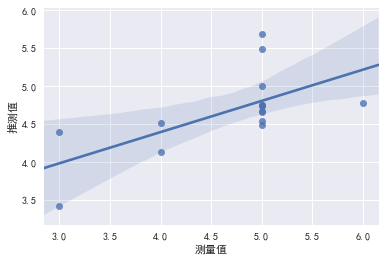

In [75]:
sns.regplot(Smell_levels,
            pd.Series(pipe.predict(X).flatten(),index=Smell_levels.index))
plt.xlabel('测量值')
plt.ylabel('推测值')

In [78]:
pipe.predict(X).flatten()

array([5.69080199, 4.54526817, 4.13349596, 4.77672859, 4.48762985,
       4.67519571, 4.50770286, 3.42052006, 4.99605995, 4.7444136 ,
       4.74402771, 4.74141188, 5.4814142 , 4.65775418, 4.39757529])

In [79]:
from sklearn.metrics import r2_score
R2 = r2_score(Smell_levels, pipe.predict(X).flatten())

0.41064347037288873

# 经典数据

In [87]:
from sklearn.datasets import load_boston

In [97]:
bos = load_boston()
X = pd.DataFrame(bos.data,columns=bos.feature_names)
y = bos.target

In [107]:
# 建模步骤 train-validation-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [104]:
# 模型步骤
steps = [('prep',StandardScaler()),
         ('regr',PLSRegression())]
pipe = Pipeline(steps=steps)

In [118]:
# 调参 validation
param_grid = {'regr__n_components':range(1,13)}
grid = GridSearchCV(pipe,param_grid=param_grid,cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

{'regr__n_components': 9}

In [141]:
cv_ = pd.DataFrame(dict(grid.cv_results_)).loc[:,['mean_test_score','mean_train_score','param_regr__n_components']].set_index('param_regr__n_components')
cv_

,mean_test_score,mean_train_score
param_regr__n_components,,
1,0.489701,0.491772
2,0.656711,0.677464
3,0.660861,0.699717
4,0.667604,0.713022
5,0.673605,0.716608
6,0.679657,0.718321
7,0.680466,0.719276
8,0.680432,0.719921
9,0.681579,0.720079


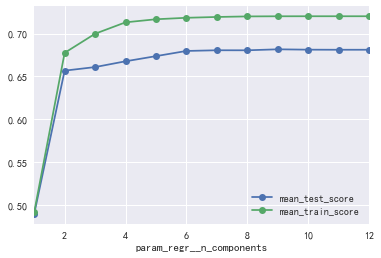

In [144]:
cv_.plot(style='-o')

In [154]:
# 模型评价 test set

In [152]:
res_table = pd.DataFrame([grid.score(X_train,y_train),grid.score(X_test,y_test)],index=['train','test'],columns=['Rsquared']).T
res_table

,train,test
Rsquared,0.716691,0.778946


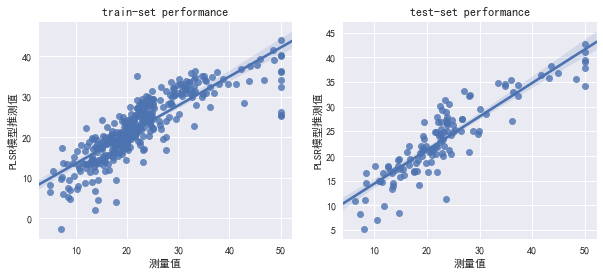

In [134]:
f = plt.figure(figsize=(10,4))
ax1 = f.add_subplot(121)
sns.regplot(y_train,y_fit.flatten(),ax=ax1)
plt.ylabel('PLSR模型推测值')
plt.xlabel('测量值')
plt.title('train-set performance')
ax2 = f.add_subplot(122)
sns.regplot(y_test,grid.predict(X_test).flatten(),ax=ax2)
plt.ylabel('PLSR模型推测值')
plt.xlabel('测量值')
plt.title('test-set performance')